**Stage 1 - Validation**

In [1]:
# @title 1. Install Dependencies
import os
import sys

# 1.1 Force Upgrade Libraries
print("Installing libraries...")
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers peft accelerate
!pip install -q moderngl
!apt-get install -y libgl1-mesa-glx > /dev/null

# 1.2 Restart Check
try:
    import bitsandbytes
    from transformers.utils import is_bitsandbytes_available
    if not is_bitsandbytes_available():
        print("\n" + "="*60)
        print("  PLEASE RESTART RUNTIME (Runtime > Restart Session)")
        print("Then run this cell again.")
        print("="*60 + "\n")
    else:
        print("  Environment Ready.")
except ImportError:
    pass

Installing libraries...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 15.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.2/516.2 kB 30.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 5.1.2 requires transformers<5.0.0,>=4.41.0, but you have transformers 5.0.0.dev0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.4/296.4 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.4/51.4 kB 5.2 MB/s eta 0:00:00
  Environment Ready.


In [2]:
# @title 2. Load Model & Adapter
import torch
from transformers import Qwen2VLForConditionalGeneration, Qwen2VLProcessor, BitsAndBytesConfig
from peft import PeftModel
import os
import sys
import importlib.util

# 2.1 Configuration
PROJECT_ROOT = '/content/drive/MyDrive/projects/EarthShader'
ADAPTER_PATH = os.path.join(PROJECT_ROOT, 'checkpoints/stage1_final')
LIB_DIR = os.path.join(PROJECT_ROOT, 'lib')

# 2.2 Mount Drive
from google.colab import drive
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# 2.3 Setup Renderer
sys.path.append(PROJECT_ROOT)
if LIB_DIR not in sys.path:
    sys.path.insert(0, LIB_DIR)

try:
    from gl_renderer import ShaderRenderer
    # Initialize renderer once to hold the context
    renderer = ShaderRenderer(width=256, height=256)
    print("[SUCCESS] Renderer ready.")
except ImportError:
    spec = importlib.util.spec_from_file_location("gl_renderer", os.path.join(LIB_DIR, "gl_renderer.py"))
    mod = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(mod)
    renderer = mod.ShaderRenderer(width=256, height=256)
    print("[SUCCESS] Renderer ready (Direct Load).")

# 2.4 Load Model
print(f"⏳ Loading Adapter from: {ADAPTER_PATH}...")

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

# Load Base
base_model = Qwen2VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-VL-7B-Instruct",
    quantization_config=bnb_config,
    device_map="auto",
    torch_dtype=torch.float16,
)

# Load Adapter
model = PeftModel.from_pretrained(base_model, ADAPTER_PATH)
processor = Qwen2VLProcessor.from_pretrained("Qwen/Qwen2-VL-7B-Instruct")

print("[SUCCESS] Model Loaded Successfully!")

Mounted at /content/drive
[SUCCESS] Renderer ready.
⏳ Loading Adapter from: /content/drive/MyDrive/projects/EarthShader/checkpoints/stage1_final...


config.json: 0.00B [00:00, ?B/s]

Unrecognized keys in `rope_parameters` for 'rope_type'='default': {'mrope_section'}


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/730 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/244 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/347 [00:00<?, ?B/s]

The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

chat_template.json: 0.00B [00:00, ?B/s]

[SUCCESS] Model Loaded Successfully!


✅ Generator library loaded.
Running Inference on 3 Random Samples...


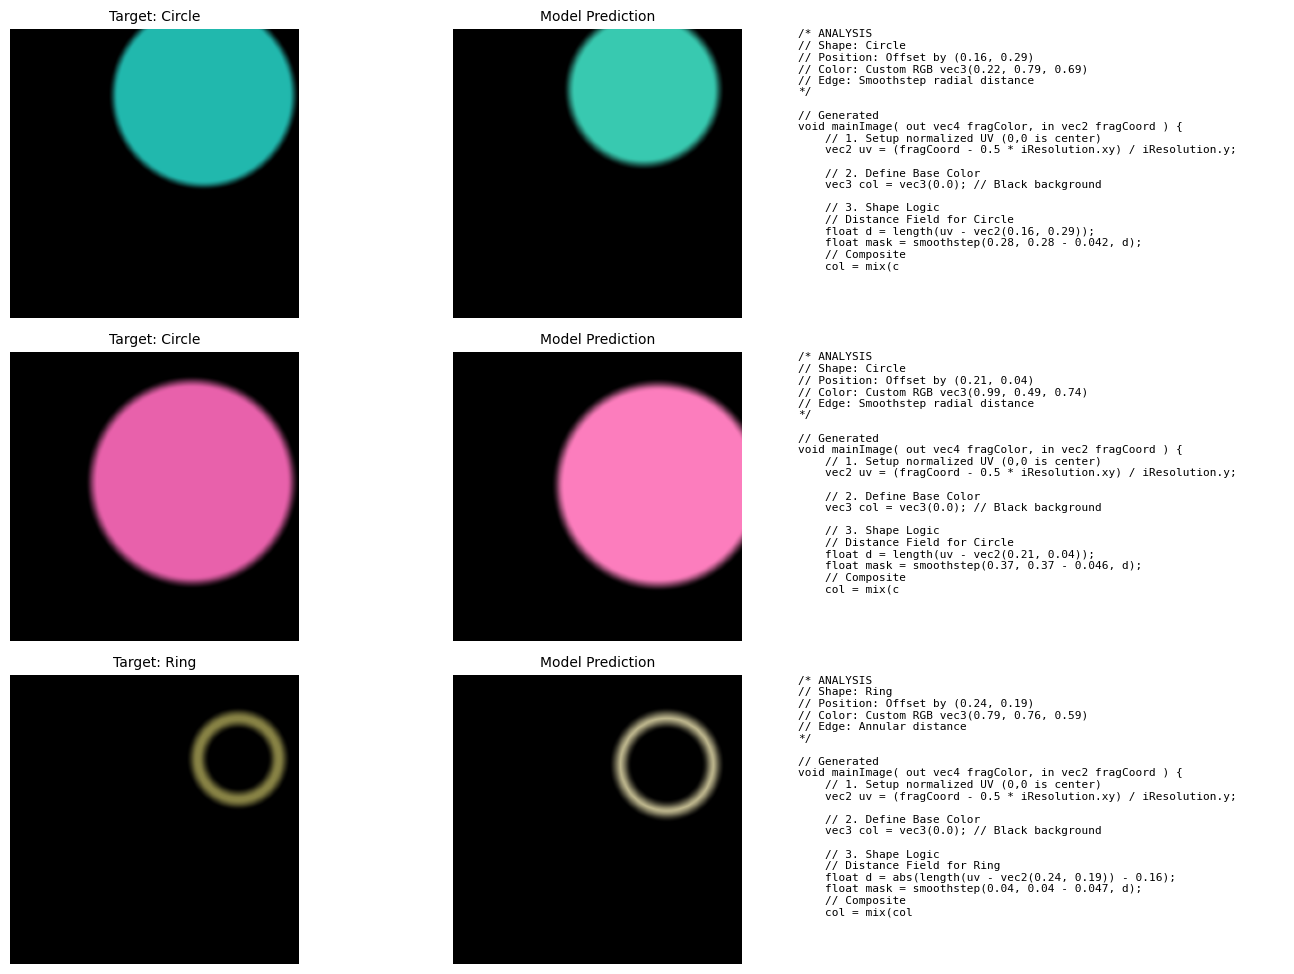

In [5]:
# @title 3. Generate & Validate Samples (Using Library)
import random
import matplotlib.pyplot as plt
from PIL import Image
import torch
import os
import sys
import re
import importlib.util

# 1. Import Generator from Library
# We assume LIB_DIR is already in sys.path from Cell 2, but let's be safe
PROJECT_ROOT = '/content/drive/MyDrive/projects/EarthShader'
LIB_DIR = os.path.join(PROJECT_ROOT, 'lib')
if LIB_DIR not in sys.path:
    sys.path.insert(0, LIB_DIR)

try:
    from generators.primitives import generate_primitive
    print("✅ Generator library loaded.")
except ImportError as e:
    print(f"Library import failed: {e}. Trying direct load...")
    # Direct load fallback if Colab package resolution is flaky
    spec_b = importlib.util.spec_from_file_location("base", os.path.join(LIB_DIR, "generators/base.py"))
    mod_b = importlib.util.module_from_spec(spec_b)
    spec_b.loader.exec_module(mod_b)

    spec_p = importlib.util.spec_from_file_location("primitives", os.path.join(LIB_DIR, "generators/primitives.py"))
    mod_p = importlib.util.module_from_spec(spec_p)
    mod_p.base = mod_b # Inject dependency
    spec_p.loader.exec_module(mod_p)
    generate_primitive = mod_p.generate_primitive

# 2. Helpers
def extract_code(text):
    if "// GLSL CODE" in text:
        return text.split("// GLSL CODE")[1].strip()
    if "```glsl" in text:
        return text.split("```glsl")[1].split("```")[0].strip()
    return text

def parse_shape_name(analysis_text):
    # Extract "Shape: Circle" from analysis block
    match = re.search(r"// Shape: (\w+)", analysis_text)
    return match.group(1) if match else "Unknown"

# 3. Inference Loop
print("Running Inference on 3 Random Samples...")
plt.figure(figsize=(15, 10))

for i in range(3):
    # A. Generate Ground Truth using Library
    gt_code, gt_analysis = generate_primitive(i)
    shape_name = parse_shape_name(gt_analysis)

    renderer.render(gt_code, "temp_gt.png")
    gt_image = Image.open("temp_gt.png").convert("RGB")

    # B. Prompt
    conversation = [
        {
            "role": "user",
            "content": [
                {"type": "image", "image": "temp_gt.png"},
                {"type": "text", "text": "Reverse engineer the GLSL shader code for this texture. Include analysis."}
            ]
        }
    ]

    text_prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)
    inputs = processor(
        text=[text_prompt],
        images=[gt_image],
        padding=True,
        return_tensors="pt"
    ).to(model.device)

    # C. Generate
    with torch.no_grad():
        output_ids = model.generate(**inputs, max_new_tokens=512)

    generated_ids = [output_ids[len(inputs.input_ids[0]):] for output_ids in output_ids]
    output_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    # D. Render Result
    pred_code = extract_code(output_text)
    renderer.render(pred_code, f"temp_pred_{i}.png")

    if os.path.exists(f"temp_pred_{i}.png"):
        pred_image = Image.open(f"temp_pred_{i}.png")
    else:
        pred_image = Image.new("RGB", (256, 256), (255, 0, 0))

    # E. Display
    # GT
    plt.subplot(3, 3, i*3 + 1)
    plt.imshow(gt_image)
    plt.title(f"Target: {shape_name}", fontsize=10)
    plt.axis('off')

    # Pred
    plt.subplot(3, 3, i*3 + 2)
    plt.imshow(pred_image)
    plt.title("Model Prediction", fontsize=10)
    plt.axis('off')

    # Code
    ax = plt.subplot(3, 3, i*3 + 3)
    clean_code = pred_code.replace("void mainImage", "// Generated\nvoid mainImage")
    plt.text(0, 1, clean_code[:600], family='monospace', fontsize=8, verticalalignment='top')
    plt.axis('off')

plt.tight_layout()
plt.show()